  Activating project at `~/LCP/fish-track/HMC`


Number of failed trajectories for horizontal bridges: 0, over 4000.0
Number of failed trajectories for oblique bridges: 3997, over 4000.0

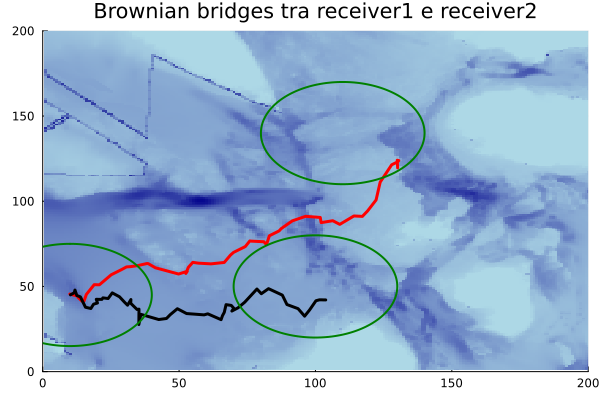

[ Info: Optimizing posterior for a MAP starting point…


Running with n_chains=6, n_rounds=10, repetition=1


In [ ]:
import Pkg

Pkg.activate(".")
Pkg.instantiate()

using Images: load, Gray, channelview
using Plots
using Dates

include("find_grid_final.jl")
gr()
Random.seed!(1274)


#--------- basics
# Load bathymetry, negative values are treated as land:
bathymetry_map = channelview(Gray.(load("bathymetry_maps/map_Firth_of_Lorn_200m.tif"))) * 100 .- 1;
bathymetry_int = extrapolate(interpolate(bathymetry_map, BSpline(Linear())),-1.0);

receiver1 = Receiver((x=10, y=45), k=30.0, dist=30.0)
receiver2 = Receiver((x=100, y=50), k=30.0, dist=30.0)
receiver3 = Receiver((x=110, y=140), k=30.0, dist=30.0)

#=receiver1 = Receiver((x=100, y=100), k=30.0, dist=30.0)
receiver2 = Receiver((x=300, y=100), k=30.0, dist=30.0)
receiver3 = Receiver((x=300, y=100), k=30.0, dist=30.0)=#

#--------- bridges
#Building bridges from receiver1 to receiver 2, which is a way to get all (if n_bridges, tmax and sigma are big enough to explore all the channels) the plausible 
#paths that the fish may have followed:
tmax = 50       #100 for toy bathimetry

n_bridges = 8000
bridges = []
failed_traj=0
n=n_bridges/2
for _ in (1:(n_bridges/2)) 
    path = simulate_unbiased_path(
        tmax;
        rec1=receiver1,
        rec2=receiver2,
        σ_step=3.0,
        bathymetry_int=bathymetry_int,
        coarse_steps=50,  #70 for toy bathimetry
        min_endpoint_prob=0.5,
        noise_σ=0.5
    )
    
    if path !== nothing
        push!(bridges, path)
    else
        failed_traj=failed_traj+1
    end
end
print("Number of failed trajectories for horizontal bridges: $failed_traj, over $n")

failed_traj=0
for _ in ((n_bridges/2 +1) : n_bridges)
    path = simulate_unbiased_path(
        tmax;
        rec1=receiver1,
        rec2=receiver3,
        σ_step=3.0,
        bathymetry_int=bathymetry_int,
        coarse_steps=65,  #70 for toy bathimetry
        min_endpoint_prob=0.5,
        noise_σ=0.5
    )
    
    if path !== nothing
        push!(bridges, path)
    else
        failed_traj=failed_traj+1
    end
end
print("\nNumber of failed trajectories for oblique bridges: $failed_traj, over $n")

bridges = filter(!isnothing, bridges)  # keep just the valid trajectories
bridges_x = [[p.x for p in bridge] for bridge in bridges]
bridges_y = [[p.y for p in bridge] for bridge in bridges]

#=plt = heatmap(bathymetry_map[end:-1:1,:],
              xlim=(0, 200), ylim=(0, 200),
              color=:blues,
              legend=false,
              title="Brownian bridges betw receiver1 e receiver2")
for i in 1:length(bridges)
    plot!(plt, bridges_x[i], bridges_y[i], lw=2)
end
plot!(plt, make_circle(receiver1.x, receiver1.y, receiver1.dist), lw=2, color=:green, label="Receiver 1")
plot!(plt, make_circle(receiver2.x, receiver2.y, receiver2.dist), lw=2, color=:green, label="Receiver 2")
plot!(plt, make_circle(receiver2.x, receiver2.y, receiver2.dist), lw=2, color=:green, label="Receiver 3")
display(plt)=#


s_init = bridges[end]
s_depth = bridges[1]

xs_d = [p.x for p in s_depth]
ys_d = [p.y for p in s_depth]

xs = [p.x for p in s_init]
ys = [p.y for p in s_init]

#scatter!(plt, [receiver1.x, receiver2.x], [receiver1.y, receiver2.y], color=:red, label="Receivers")

plt2 = heatmap(bathymetry_map[end:-1:1,:],
              xlim=(0, 200), ylim=(0, 200),
              color=:blues,
              legend=false,
              title="Brownian bridges tra receiver1 e receiver2")
plot!(plt2, xs, ys, lw=3, color=:red, label="chosen trajectory")
plot!(plt2, xs_d, ys_d, lw=3, color=:black, label="goal trajectory")
plot!(plt2, make_circle(receiver1.x, receiver1.y, receiver1.dist), lw=2, color=:green, label="activation 1")
plot!(plt2, make_circle(receiver2.x, receiver2.y, receiver2.dist), lw=2, color=:green, label="activation 2")
plot!(plt2, make_circle(receiver3.x, receiver3.y, receiver3.dist), lw=2, color=:green, label="activation 3") #for real bathy
display(plt2)

#--------- data
# Accustic signals:
receivers = [receiver1, receiver2]
Yaccustic = build_Yaccustic_from_trajectory(s_depth, receivers)

#Depth signal:
Ydepth = Tuple{Int, Float64, DepthGauge}[] 
depthgauge = DepthGauge()

#"Geolocating Fish Using Hidden Markov Models and Data Storage Tags" uses uniform noise in [-10,10], and a "depth model" that is a gaussian with sigma 15
for (t, point) in enumerate(s_depth)
    # Get the depth from the bathymetry
    d = get_depth((x=point.x, y=point.y), bathymetry_int)
    noisy_d = d + rand(Uniform(-10, 10))   #-1,1  for toy bahtimetry
    push!(Ydepth, (t+1, noisy_d, depthgauge))
end

#For gaussian noise instead
#=sigma_noise=0.5
for (t, point) in enumerate(bridges[2])
    d = get_depth((x=point.x, y=point.y), bathymetry_int)
    noisy_d = d + randn() * sigma_noise
    push!(Ydepth, (t+1, noisy_d, depthgauge))
end=#

#--------- PT 
@info "Optimizing posterior for a MAP starting point…"              

#Setting the problem characteristics:
mapping = TransformVariables.as(Array, 
                                TransformVariables.as((x = TransformVariables.asℝ, y = TransformVariables.asℝ)),
                                tmax)
v_init = TransformVariables.inverse(mapping, s_init)

fish_lp = FishLogPotential(Ydepth, Yaccustic, bathymetry_int, mapping, v_init, bridges)
fish_ref = FishReferencePotential(bathymetry_int, mapping, v_init, bridges)


# Grid search ranges
n_chains_list = [6]
n_rounds_list = [10]
n_repeats = 1  # Number of repetitions

# Store results
all_trajectories = []
all_logposteriors = []
logpost_cold_values = Float64[]
std_devs = Float64[]
prof=[]

# Placeholder Ydepth for scatter comparison
Ydepth_values = [y[2] for y in Ydepth]  # assuming Ydepth is defined


#=Pkg.add("PairPlots")
Pkg.add("CairoMakie")
using PairPlots
using CairoMakie=#


for n_chains in n_chains_list
    for n_rounds in n_rounds_list
        timestamp = Dates.format(now(), "yyyy-mm-dd_HHMMSS")
        for rep in 1:n_repeats
            println("Running with n_chains=$n_chains, n_rounds=$n_rounds, repetition=$rep")
            find_grid_path = abspath("find_grid.jl")
            pt_results = pigeons(
                target        = fish_lp,
                reference     = fish_ref,
                seed          = rep,  # vary seed for reproducibility
                n_rounds      = n_rounds,
                n_chains      = n_chains,
                checkpoint    = true,
                multithreaded = true,
                on = ChildProcess(n_local_mpi_processes = 5,
                                  n_threads=2,
                                  dependencies = [find_grid_path]),
                explorer      = SliceSampler(),#=AutoMALA(
                           step_size            = 6.0,           # passo iniziale MALA
                           base_n_refresh       = 13,     #13        # passi base per esplorazione
                           exponent_n_refresh   = 0.5,           # scala con √dim
                           default_autodiff_backend = AutoEnzyme()        # backend autodiff
                       ),=#
                record        = [traces, online, round_trip, Pigeons.timing_extrema, Pigeons.allocation_extrema, index_process]
            )
            pt = Pigeons.load(pt_results)
            pt_samples = Chains(pt)
            myplot3 = plot(pt.reduced_recorders.index_process, title="chains=$n_chains, rounds=$n_rounds")
            folder_path = "images/index_process"
            mkpath(folder_path)
            savefig(myplot3, "images/index_process/" * timestamp * ".svg")
            #myplot4 = pairplot(pt_samples) 
            #CairoMakie.save("pair_plot5.svg", myplot4)
            cold_last_v = pt_samples.value[end, 1:2*tmax] |> vec
            cold_last_S = TransformVariables.transform(mapping, cold_last_v)

            push!(all_trajectories, cold_last_S)

            logposteriors = [fish_lp(pt_samples.value[i, 1:2*tmax]) for i in 1:size(pt_samples.value, 1)]
            push!(all_logposteriors, logposteriors)

            # Log posterior of last cold chain sample
            logpost_cold = fish_lp(cold_last_v)
            push!(logpost_cold_values, logpost_cold)

            # Depth measurement
            YdepthPIGEONS = Tuple{Int, Float64, DepthGauge}[] 
            for (t, point) in enumerate(cold_last_S)
                d = get_depth((x=point.x, y=point.y), bathymetry_int)
                push!(YdepthPIGEONS, (t+1,d, depthgauge))
            end

            profonditaP = [y[2] for y in YdepthPIGEONS]
            push!(prof, profonditaP)
            std_dev = std(profonditaP .- Ydepth_values[1:length(profonditaP)])
            push!(std_devs, std_dev)
        end
    end
end




Log-posterior initial bridge: -508.23188253282507
Log-posterior depth bridge: -444.5989567575385
Log-posterior pigeons: -454.58113913554746


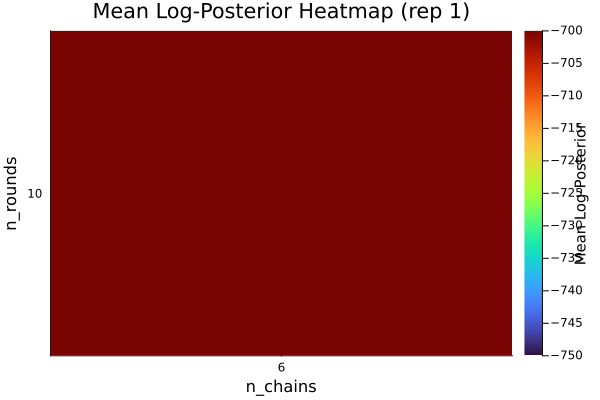

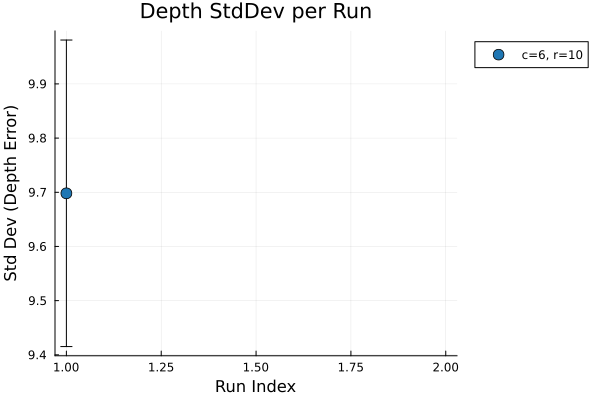

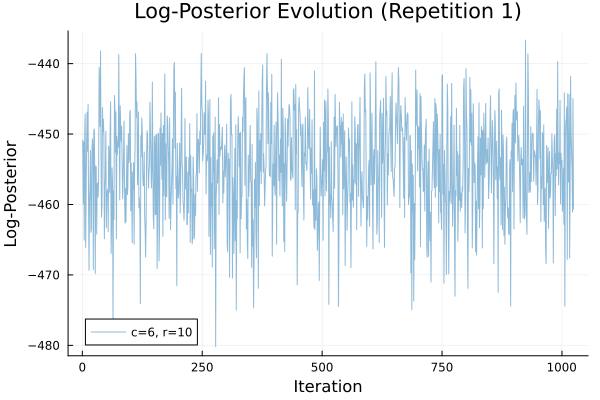

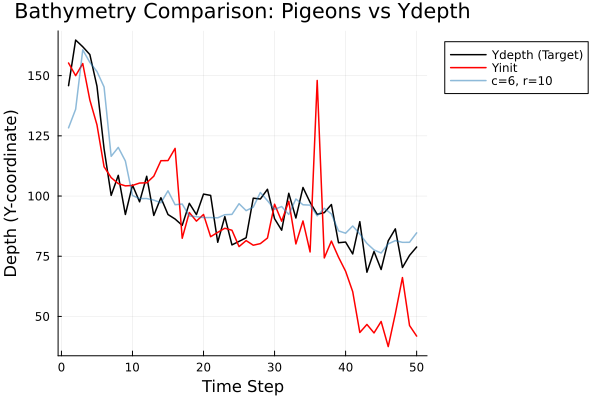

"/home/piewsl/LCP/fish-track/HMC/images/bathy_comparison/2025-10-02_213842.svg"

In [24]:
#Run this cell to plot the results of the computation performed by the cell above
gr()
timestamp = Dates.format(now(), "yyyy-mm-dd_HHMMSS")

c=n_chains_list[1]
r=n_rounds_list[1]
# Style maps
colors_map = Dict(nc => palette(:tab10)[i] for (i, nc) in enumerate(n_chains_list))
linestyles_map = Dict(nr => [:solid, :dash, :dot, :dashdot, :dashdotdot, :solid][i] for (i, nr) in enumerate(n_rounds_list))
markers_map = Dict(nr => [:circle, :star5, :diamond, :utriangle, :square, :xcross][i] for (i, nr) in enumerate(n_rounds_list))

#TRAJECTORY PLOT
plt = heatmap(bathymetry_map[end:-1:1, :],
              xlim=(0, 200), ylim=(0, 200),
              color=:blues, title="Pigeons Trajectories", legend=:outertopright)

plot!(plt, xs, ys, lw=3, color=:red, label="Starting Trajectory")
plot!(plt, xs_d, ys_d, lw=3, color=:black, label="Goal Trajectory")
plot!(plt, make_circle(receiver1.x, receiver1.y, receiver1.dist), color=:green, label="activation 1")
plot!(plt, make_circle(receiver2.x, receiver2.y, receiver2.dist), color=:green, label="activation 2")
plot!(plt, make_circle(receiver3.x, receiver3.y, receiver3.dist), color=:green, label="activation 3")
scatter!(plt, [receiver1.x, receiver2.x, receiver3.x], [receiver1.y, receiver2.y, receiver3.y], color=:red, label="Receivers")

n_repeat = n_repeats
for (i, traj) in enumerate(all_trajectories)
    rep_index = mod(i - 1, n_repeat) + 1
    combo_index = div(i - 1, n_repeat)

    n_chains = n_chains_list[div(combo_index, length(n_rounds_list)) + 1]
    n_rounds = n_rounds_list[mod(combo_index, length(n_rounds_list)) + 1]

    xs_p = [p.x for p in traj]
    ys_p = [p.y for p in traj]

    plot!(plt, xs_p, ys_p,
          lw = 1,
          color = colors_map[n_chains],
          linestyle = linestyles_map[n_rounds],
          label = "c=$n_chains, r=$n_rounds")
end

display(plt)
folder_path = "images/trajectories"
mkpath(folder_path)
savefig(plt, "images/trajectories/$c-$r-" * timestamp * ".svg")

v_init = TransformVariables.inverse(mapping, s_init)
v_depth = TransformVariables.inverse(mapping, s_depth)
logpost_init = fish_lp(v_init)
logpost_depth = fish_lp(v_depth)
println("Log-posterior initial bridge: ", logpost_init)
println("Log-posterior depth bridge: ", logpost_depth)
if (n_repeat==1)
    #print(all_logposteriors)
    logpost_pg = mean(all_logposteriors[1])
    println("Log-posterior pigeons: ", logpost_pg)
end

#LOGPOST HEATMAPS FOR EACH REPETITION
# Fixed color limits for all heatmaps
clims = (-750.0, -700.0)

xticks = (1:length(n_chains_list), string.(n_chains_list))
yticks = (1:length(n_rounds_list), string.(n_rounds_list))

for rep in 1:n_repeat
    mean_logpost_matrix = fill(NaN, length(n_rounds_list), length(n_chains_list))

    for i in 1:length(all_logposteriors)
        current_rep = mod(i - 1, n_repeat) + 1
        if current_rep == rep
            combo_index = div(i - 1, n_repeat)
            row = mod(combo_index, length(n_rounds_list)) + 1
            col = div(combo_index, length(n_rounds_list)) + 1
            mean_logpost_matrix[row, col] = mean(all_logposteriors[i])
        end
    end

    plt_heatmap = heatmap(
        mean_logpost_matrix;
        xlabel = "n_chains",
        ylabel = "n_rounds",
        xticks = xticks,
        yticks = yticks,
        colorbar_title = "Mean Log-Posterior",
        title = "Mean Log-Posterior Heatmap (rep $rep)",
        c = :turbo,
        clims = clims 
    )

    display(plt_heatmap)
    folder_path = "images/heatmaps"
    mkpath(folder_path)
    savefig(plt_heatmap, "images/heatmaps/$c-$r-$rep-" * timestamp * ".svg")
end

#SCATTER PLOT OF STD DEVIATIONS
scatter_plot = plot(title="Depth StdDev per Run",
                    xlabel="Run Index", ylabel="Std Dev (Depth Error)", legend=:outertopright)

for i in 1:length(std_devs)
    rep_index = mod(i - 1, n_repeat) + 1
    combo_index = div(i - 1, n_repeat)

    n_chains = n_chains_list[div(combo_index, length(n_rounds_list)) + 1]
    n_rounds = n_rounds_list[mod(combo_index, length(n_rounds_list)) + 1]

    N = length(all_trajectories[i])
    sem = 2 / sqrt(N) #2 for toy bathy, 15 for real bathy

    scatter!(scatter_plot, [i], [std_devs[i]],
             yerr = [sem],
             markersize = 6,
             marker = markers_map[n_rounds],
             color = colors_map[n_chains],
             label = "c=$n_chains, r=$n_rounds")
end

display(scatter_plot)
folder_path = "images/std_dev"
mkpath(folder_path)
savefig(scatter_plot, "images/std_dev/$c-$r-" * timestamp * ".svg")

#LOGPOST EVOLUTION
for rep in 1:n_repeat
    plt_log = plot(
        title = "Log-Posterior Evolution (Repetition $rep)",
        xlabel = "Iteration",
        ylabel = "Log-Posterior"
    )

    for (i_nc, n_chains) in enumerate(n_chains_list)
        for (i_nr, n_rounds) in enumerate(n_rounds_list)
            # Compute the index in all_logposteriors
            # order: first vary rounds, then chains, then repetitions
            index = (rep - 1) * length(n_chains_list) * length(n_rounds_list) +
                    (i_nc - 1) * length(n_rounds_list) + i_nr

            lp = all_logposteriors[index]

            plot!(
                plt_log, lp;
                color = colors_map[n_chains],
                linestyle = linestyles_map[n_rounds],
                alpha = 0.5,
                label = "c=$n_chains, r=$n_rounds"
            )
        end
    end

    display(plt_log)
    folder_path = "images/logpost"
    mkpath(folder_path)
    savefig(plt_log, "images/logpost/$c-$r-$rep-" * timestamp * ".svg")
end


#BATHIMETRY COMPARISON
plt_bathy = plot(
    title = "Bathymetry Comparison: Pigeons vs Ydepth",
    xlabel = "Time Step",
    ylabel = "Depth (Y-coordinate)",
    legend = :outertopright
)

Yinit = Tuple{Int, Float64, DepthGauge}[] 
for (t, point) in enumerate(bridges[end])
    d = get_depth((x=point.x, y=point.y), bathymetry_int)
    push!(Yinit, (t+1,d, depthgauge))
end
Yinit_d= [y[2] for y in Yinit]

# Plot Ydepth as reference
plot!(plt_bathy, Ydepth_values, lw = 1.5, color = :black, label = "Ydepth (Target)")
plot!(plt_bathy, Yinit_d, lw = 1.5, color = :red, label = "Yinit")

# Overlay all Pigeons-found trajectories
for (i, traj) in enumerate(prof)
    depths = traj

    # Get corresponding n_chains and n_rounds
    n_total = length(n_rounds_list)
    n_chains = n_chains_list[div((i - 1) % (length(n_chains_list) * n_total), n_total) + 1]
    n_rounds = n_rounds_list[mod(i - 1, n_total) + 1]

    plot!(
        plt_bathy,
        depths;
        lw = 1.5,
        color = colors_map[n_chains],
        linestyle = linestyles_map[n_rounds],
        alpha = 0.5,
        label = "c=$n_chains, r=$n_rounds"
    )
end

display(plt_bathy)
folder_path = "images/bathy_comparison"
mkpath(folder_path)
savefig(plt_bathy, "images/bathy_comparison/" * timestamp * ".svg")